In [ ]:
#hide
import networkm
from networkm import *

Warming up integrator; future calls will be accelerated.
bool_integral : Elapsed time: 2.6237 seconds
bool_integral_risefall : Elapsed time: 0.0000 seconds


# networkm

> Network Models based on networkx MultiDiGraph objects endowed with dynamics. `Graph Functions` contains various manipulation tools for MultiDiGraphs. `Model Functions` contains methods of simulating these graphs as coupled, time-delayed differential equations with noise. `Network Class` contains the culmination of these functions in a single class object for pipelined analysis. 

## Install

NYI: `pip install networkm`

## How to use

NYI: Check out the other pages for examples

bool_integral : Elapsed time: 0.0104 seconds


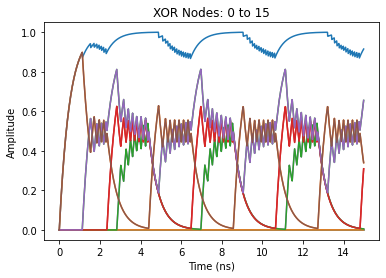

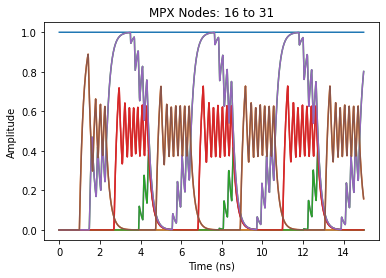

In [ ]:
m=BooleanNetwork()

In [ ]:
m

|Node|Predecessors|Successors|
|0   |16, 17, 31  |16        |
|1   |16, 17, 18  |17        |
|2   |17, 18, 19  |18        |
|3   |18, 19, 20  |19        |
...
|28  |12          |11, 13, 12|
|29  |13          |12, 14, 13|
|30  |14          |13, 15, 14|
|31  |15          |14, 0, 15 |